In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
            main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            return main_term + cross_entropy 
            
#         for x in batch:
#             t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            
#             cross_entropy = log_kde_pdf_per_point(Xt[terminal_index].reshape(-1,1), batch_terminal_empirical, H)
            
#             J += cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            
#             J += cross_entropy
        
#         J /= len(batch)
        J = np.mean(inner_loss_loop(batch))
        J = np.squeeze(J)
#         J = J.block_until_ready() 
        return J
    
    @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        def inner_loss_loop_23(x_):
            t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=100, theta=theta)
            return Xt[:,-1,:]

        return inner_loss_loop_23(batch_x)
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in tqdm(range(IPFP_iterations)):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

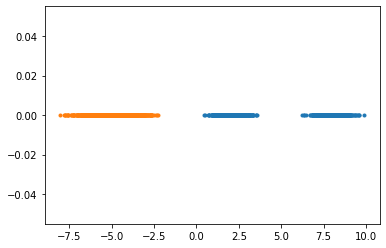

In [3]:
n = 1000
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 8
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [4]:
c = cIPFP(X2, X1,  number_time_steps=200, batch_size=100 , step_size = 0.0001, weights=[500,250])

In [5]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [6]:
theta_f[0][1].shape, theta_f[1]

((500,), ())

In [7]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

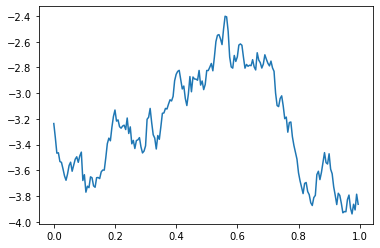

In [8]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [289]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [14]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [15]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [16]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 752 ms, sys: 10.3 ms, total: 762 ms
Wall time: 810 ms


DeviceArray(61.630344, dtype=float32)

In [17]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 16.8 ms, sys: 55 µs, total: 16.8 ms
Wall time: 10.5 ms


DeviceArray(68.25656, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [18]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.81 s, sys: 25.1 ms, total: 2.84 s
Wall time: 3.39 s


In [19]:
%%time
kek = gradient(theta_f, X1, True)

CPU times: user 6.91 ms, sys: 588 µs, total: 7.5 ms
Wall time: 2.79 ms


loss b 47.03510284423828
loss f 715.6668090820312



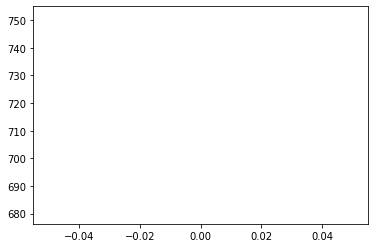

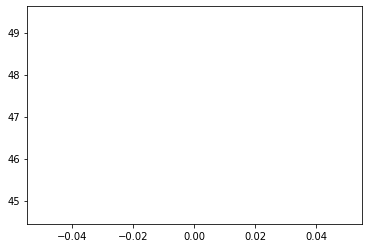

CPU times: user 1min 54s, sys: 6.59 s, total: 2min
Wall time: 4min 32s


In [9]:
%%time
c.fit(1,1)

loss b 43.80569839477539
loss f 596.4473876953125



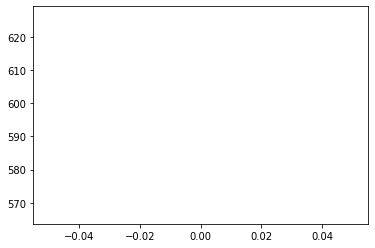

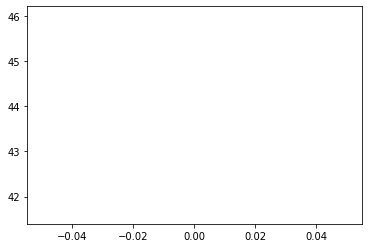

CPU times: user 32.8 s, sys: 6.89 s, total: 39.7 s
Wall time: 34.8 s


In [ ]:
%%time
c.fit(1,1)

In [ ]:
c.fit(150,30)

loss b 49.327457427978516
loss b 35.634300231933594
loss b 31.647058486938477
loss b 27.21755599975586
loss b 28.626752853393555
loss b 24.27619171142578
loss b 20.778738021850586
loss b 16.20216941833496


In [ ]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
for x1 in X2:
    t, Xt = c.sample_trajectory(x1.reshape(1,-1),c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, forwards=True)
    axs[0].plot(t.flatten(), Xt.flatten(), 'b', alpha=0.03, )
BXt = []   

for x2 in X1:
    t_, Xt_ = c.sample_trajectory(x2.reshape(1,-1),c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver, forwards=False)
    BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten()[0:100], Xt_.flatten(), 'r', alpha=0.03)


In [25]:
import jax.numpy as np
import numpy as onp
import jax
import pylab as pl
from jax import jit
from functools import partial

key = jax.random.PRNGKey(0)
# key = None
onp.random.seed(0)


@partial(jit, static_argnums=(0,1, 4))
def inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta):
    N = int(N)
    alfa_ = alfa
    if theta is not None:
        alfa_ = lambda X,t: alfa(theta, X)
        
    def inner_loop(n, Y):
        t = ti[n]
        a, b, DWn = alfa_(Y[:,n, :], t), beta(Y[:,n, :], t), DWs[:,n,:]
        # print Y[n,:]
        newY = (  
            Y[:,n, :] + a * Dn + b * DWn * Wn + 
            0.5 * ( beta(Y[:,n, :] + b * np.sqrt(Dn), t) - b ) * 
            (DWn**2.0 - Dn) / np.sqrt(Dn)
        )
        
        Y = jax.ops.index_update(Y, jax.ops.index[:,n+1,:],  newY)
        return Y
    
    Y = jax.lax.fori_loop (0, N-1, inner_loop, Y)

    return ti, Y


# @jit
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                key = key, theta=None):
    """
            Kloeden - Numerical Solution of stochastic differential
            equations (Springer 1992)  page XXX.
            Strong order 1.0 Runge Kutta scheme.
            http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_%28SDE%29
            dX = a(X,t)*dt + b(X, t)*dW
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
    randn = onp.random.randn
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")
    n, d = X0.shape
        
    X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
    DWs  = randn(n, N-1, d)  * np.sqrt(dt)
    
    
    Y, ti = np.zeros((n, N, d)), np.arange(N)*dt + t0
    Y = jax.ops.index_update(Y, jax.ops.index[:,0,:],  X0)
    
    Dn, Wn = dt, 1
        
    return inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta)

In [62]:
# @partial(jit, static_argnums=(0,2))
npr.seed(0)
def transport_batch(self, batch_x, forwards):
    theta = self.theta_f if forwards else self.theta_b    
    b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

    def inner_loss_loop_23(x_):
        t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=100, theta=theta)
        return Xt[:,-1,:]

    return inner_loss_loop_23(batch_x)

In [63]:
# X22 = transport_batch(c, X1, True)

In [70]:
X11 = np.array(transport_batch(c, X2, True)).flatten()

In [71]:
X22 = np.array(transport_batch(c, X1, False)).flatten()

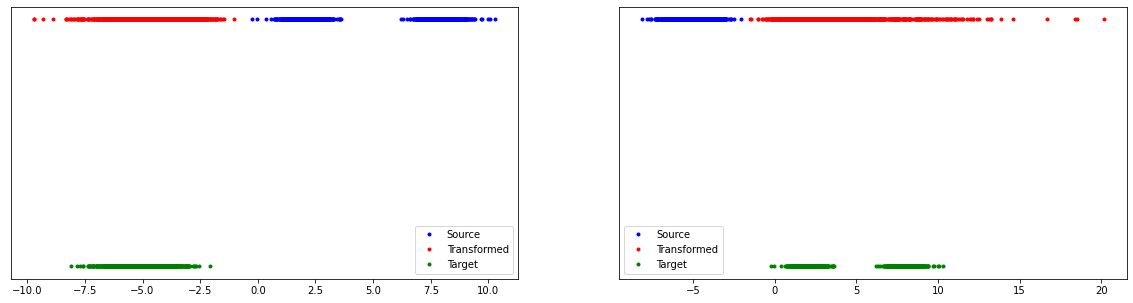

In [72]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

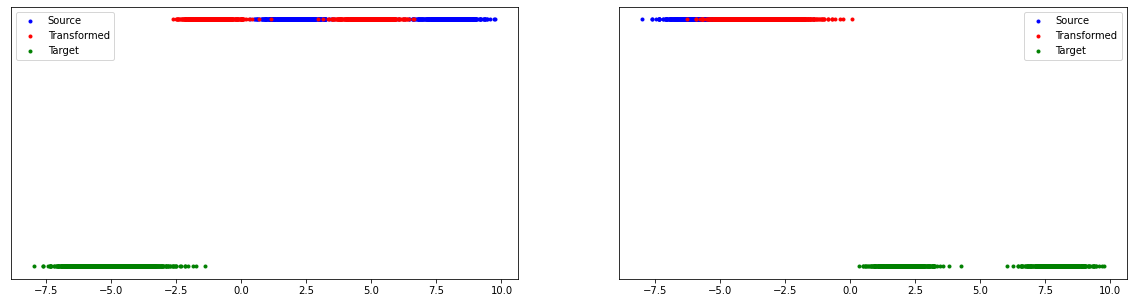

In [848]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

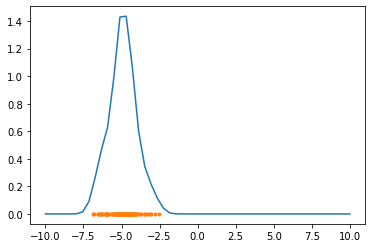

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

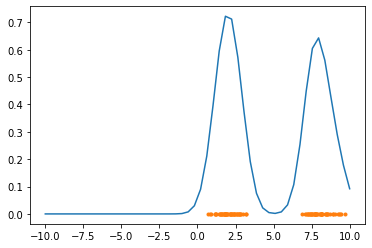

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")